## Simulating Risk Factors 

Under each scenario, consider a number $K$ of stochastic risk factors. Assuming value $P_{k,t}$ of the risk factor $k$ at time $t$ under the scenario $i$ follows an autoregressive dynamics with scenario-dependent mean $\mu_{k,t}^i$. 

In matrix form, we denote by $P_t$ the $K$-diemsnional vector of risk factors, by $\mu_t^i$ the vector of scenario-dependent means, by $\Phi$ the $(K \times K)$ matrix of mean reversion rates and by $\sigma$ the Cholesky decomposition of the instantaneous variance-covariance matrix of the risk factors:

\begin{equation}
P_t = \tilde{P}_t + \mu^i_t 
\end{equation}

\begin{equation}
\tilde{P}_t = \Phi \tilde{P}_{t-1} + \sigma \epsilon_t
\end{equation}


### Step 1: Data Preprocessing

Before estimatin $\Phi$ (mean reversion) and $\Sigma$ (volatility), the paper outlines these preprocessing steps:

1. De-trend series: substract the annual mean level and apply a linear trend correction

### Step 2: Estimate $\Phi$ (Mean Reversion Matrix)

We estimate $\Phi$ using a Vector Autoregressive (VAR(1)) model via Maximum Likelihood Estimation (MLE). The model is defined as:

\begin{equation}
\tilde{P}_t = \Phi \tilde{P}_{t-1} + \epsilon_t
\end{equation}

where $\tilde{P}_{t}$ is the de-trended series of risk factors vector.

with $\hat{\Phi}$ the MLE estimate of $\Phi$. The authors in the paper only retain diagonal elements and significant off-dianola elements (p-values < 0.05) of $\hat{\Phi}$.

### Step 3: Estimate $\Sigma$ (Covariance Matrix of Shocks)

After estimating $\Phi$, compute the residuals:

\begin{equation}
\epsilon_t = \tilde{P}_t - \hat{\Phi} \tilde{P}_{t-1}
\end{equation}

Then, estimate $\Sigma$ using the residuals:

\begin{equation}
\Sigma = \frac{1}{T-1} \sum_{t=1}^{T} \epsilon_t \epsilon_t^T
\end{equation}

with only significant entries (p-values < 0.05) retained.



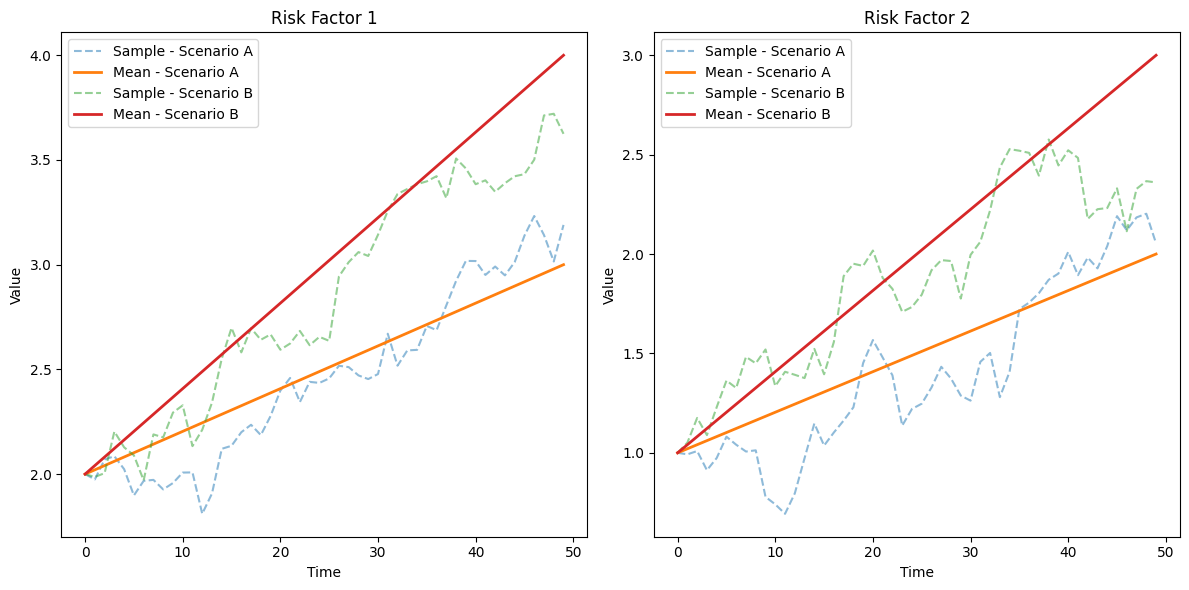

In [102]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_risk_factors(K, T, scenarios, Phi, Sigma, mu_scenario, seed=None):
    """
    Simulates stochastic risk factors under different transition scenarios.
    
    Parameters:
    K : int
        Number of risk factors.
    T : int
        Number of time steps.
    scenarios : list
        List of scenario names.
    Phi : np.ndarray (KxK)
        Mean reversion matrix.
    Sigma : np.ndarray (KxK)
        Cholesky decomposition of variance-covariance matrix.
    mu_scenario : dict
        Dictionary mapping scenario names to (TxK) matrices of scenario-dependent means.
    seed : int, optional
        Random seed for reproducibility.
    
    Returns:
    dict
        Dictionary containing simulated risk factors for each scenario.
    """
    if seed is not None:
        np.random.seed(seed)
    
    simulations = {scenario: np.zeros((T, K)) for scenario in scenarios}
    sample_paths = {scenario: np.zeros((T, K)) for scenario in scenarios}
    
    for scenario in scenarios:
        mu_t = mu_scenario[scenario]  # Scenario-dependent mean (T x K)
        
        P_tilde = np.zeros((T, K))
        P = np.zeros((T, K))
        
        for t in range(T):
            if t == 0:
                P[t] = mu_t[t]
            else:
                epsilon_t = np.random.randn(K)  # Standard normal noise
                P_tilde[t] = Phi @ P_tilde[t-1] + Sigma @ epsilon_t
                P[t] = P_tilde[t] + mu_t[t]  # Use time-dependent scenario mean
        
        simulations[scenario] = np.mean(P, axis=0)
        sample_paths[scenario] = P
    
    return simulations, sample_paths

# Example parameters
K = 2  # Two risk factors (e.g., Carbon price, Demand for low-carbon energy)
T = 50  # Simulate for 100 time steps
scenarios = ["Scenario A", "Scenario B"]

# Mean reversion matrix (stability ensured by diagonal dominance)
Phi = np.array([[0.7, 0.1],
                [0.2, 0.8]])

# Cholesky decomposition of variance-covariance matrix
Sigma = np.array([[0.1, 0.0],
                  [0.05, 0.1]])

# Scenario-dependent means (time-varying trends)
mu_scenario = {
    "Scenario A": np.array([np.linspace(2, 3, T), np.linspace(1, 2, T)]).T,
    "Scenario B": np.array([np.linspace(2, 4, T), np.linspace(1, 3, T)]).T
}

# Simulate risk factors
sim_results, sample_paths = simulate_risk_factors(K, T, scenarios, Phi, Sigma, mu_scenario)

# Plot results by risk factor
plt.figure(figsize=(12, 6))
for k in range(K):
    plt.subplot(1, K, k+1)
    for scenario in scenarios:
        plt.plot(sample_paths[scenario][:, k], alpha=0.5, linestyle='dashed', label=f"Sample - {scenario}")
        plt.plot(mu_scenario[scenario][:, k], label=f"Mean - {scenario}", linewidth=2)
    plt.title(f"Risk Factor {k+1}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
plt.tight_layout()
plt.show()


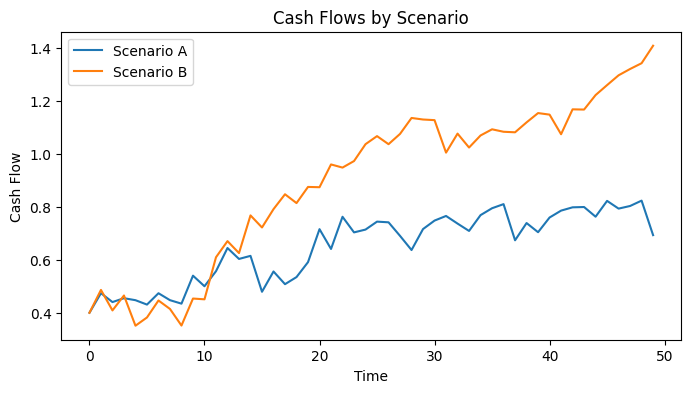

In [92]:
def compute_cash_flows(P, carbon_intensity, fossil_fuel_rev):

    cash_flow = np.zeros(P.shape[0])

    for t in range(P.shape[0]):
        carbon_tax = carbon_intensity * P[t, 0]
        revenue = fossil_fuel_rev * P[t, 1] / (P[0,1])
        cash_flow[t] = max(0,revenue - carbon_tax)
    
    return cash_flow


# Example parameters

carbon_intensity = 0.05  # Carbon tax per unit of carbon price
fossil_fuel_rev = 0.5  # Revenue per unit of fossil fuel demand


# Compute cash flows for each scenario
cash_flows = {scenario: compute_cash_flows(sample_paths[scenario], carbon_intensity, fossil_fuel_rev) for scenario in scenarios}


# Plot cash flows by scenario
plt.figure(figsize=(8, 4))
for scenario in scenarios:
    plt.plot(cash_flows[scenario], label=scenario)
plt.title("Cash Flows by Scenario")

plt.xlabel("Time")
plt.ylabel("Cash Flow")
plt.legend()
plt.show()


In [93]:
def compute_dcf(cash_flows, discount_rate):

    dcf = np.zeros(len(cash_flows))
    for t in range(len(cash_flows)):
        dcf[t] = cash_flows[t] / (1 + discount_rate)**t
    return sum(dcf)


# Example parameters
discount_rate = 0.05  # Discount rate

# Compute discounted cash flows for each scenario
dcfs = {scenario: compute_dcf(cash_flows[scenario], discount_rate) for scenario in scenarios}

# Print discounted cash flows
for scenario in scenarios:
    print(f"Scenario: {scenario} - DCF: {dcfs[scenario]:.2f}")



Scenario: Scenario A - DCF: 10.92
Scenario: Scenario B - DCF: 13.41


/tmp/ipykernel_152748/2838866480.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_152748/2838866480.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


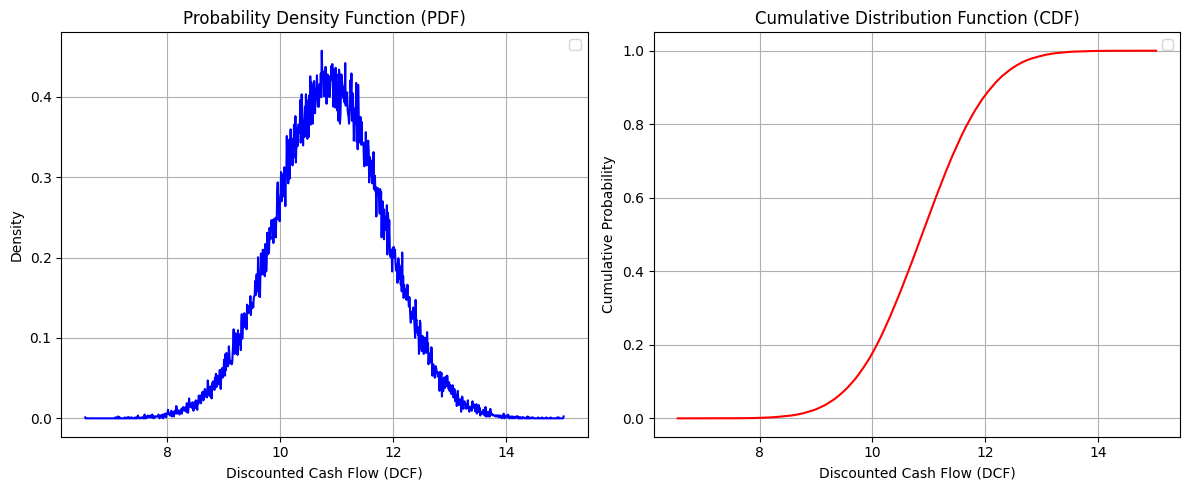

In [94]:
import numpy as np


# Re-defining the compute_cash_flows and compute_dcf functions
def compute_cash_flows(P, carbon_intensity, fossil_fuel_rev):
    """
    Compute cash flows based on risk factor projections.
    
    Parameters:
    P : np.ndarray (T, K)
        Simulated risk factor paths.
    carbon_intensity : float
        Carbon tax per unit of carbon price.
    fossil_fuel_rev : float
        Revenue per unit of fossil fuel demand.

    Returns:
    np.ndarray
        Cash flow time series.
    """
    cash_flow = np.zeros(P.shape[0])
    for t in range(P.shape[0]):
        carbon_tax = carbon_intensity * P[t, 0]
        revenue = fossil_fuel_rev * P[t, 1] / (P[0,1])
        cash_flow[t] = revenue - carbon_tax
    return cash_flow

def compute_dcf(cash_flows, discount_rate):
    """
    Compute the discounted cash flow (DCF) by discounting projected cash flows.

    Parameters:
    cash_flows : np.ndarray
        Time series of projected cash flows.
    discount_rate : float
        Discount rate for DCF computation.

    Returns:
    float
        Discounted cash flow.
    """
    return np.sum(cash_flows / (1 + discount_rate) ** np.arange(len(cash_flows)))


# Fixing the bin size issue in PDF computation
def make_cdf(data, num_bins=1000):
    """
    Compute the empirical PDF and CDF of a given dataset.

    Parameters:
    data (array-like): Input data for which to compute the distributions.
    num_bins (int): Number of bins for distribution estimation.

    Returns:
    x_range (numpy array): Sorted values of data for plotting.
    pdf_values (numpy array): Probability density function (PDF) values.
    cdf_values (numpy array): Cumulative distribution function (CDF) values.
    """
    min_x, max_x = np.min(data), np.max(data)
    x_range = np.linspace(min_x, max_x, num_bins)
    pdf_values, bin_edges = np.histogram(data, bins=num_bins, density=True)
    cdf_values = np.cumsum(pdf_values) / np.sum(pdf_values)
    
    # Use bin centers instead of edges to match dimensions
    x_range = (bin_edges[:-1] + bin_edges[1:]) / 2  
    
    return x_range, pdf_values, cdf_values

num_simulations = 100000  # Number of Monte Carlo simulations 
scenario_probabilities = {"Scenario A": 0.8, "Scenario B": 0.2}  

# Re-run the Monte Carlo simulation with weighted cash flows
weighted_cash_flows = np.zeros((num_simulations, T))

for scenario in scenarios:
    weight = scenario_probabilities[scenario]
    
    for i in range(num_simulations):
        P_tilde = np.zeros((T, K))
        P = np.zeros((T, K))
        mu_t = mu_scenario[scenario]  # Scenario-dependent mean (T x K)

        for t in range(T):
            if t == 0:
                P[t] = mu_t[t]
            else:
                epsilon_t = np.random.randn(K)  # Standard normal noise
                P_tilde[t] = Phi @ P_tilde[t-1] + Sigma @ epsilon_t
                P[t] = P_tilde[t] + mu_t[t]  # Use time-dependent scenario mean

        # Compute weighted cash flows
        weighted_cash_flows[i] += weight * compute_cash_flows(P, carbon_intensity, fossil_fuel_rev)

# Compute the DCF for each simulation using the weighted cash flows
weighted_dcf_samples = np.array([compute_dcf(weighted_cash_flows[i], discount_rate) for i in range(num_simulations)])

# Compute the PDF and CDF of the weighted expected DCF distribution
weighted_x_range, weighted_pdf, weighted_cdf = make_cdf(weighted_dcf_samples)

# Plot results
plt.figure(figsize=(12, 5))

# Plot PDF
plt.subplot(1, 2, 1)
plt.plot(weighted_x_range, weighted_pdf, color='b')
plt.xlabel("Discounted Cash Flow (DCF)")
plt.ylabel("Density")
plt.title("Probability Density Function (PDF)")
plt.legend()
plt.grid(True)

# Plot CDF
plt.subplot(1, 2, 2)
plt.plot(weighted_x_range, weighted_cdf, color='r')
plt.xlabel("Discounted Cash Flow (DCF)")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution Function (CDF)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [91]:
from scipy.stats import norm

def assign_risk_rating(cdf_values, x_range, R_distress):
    """
    Assigns a risk rating based on the probability of revenue falling below R_distress.

    Parameters:
    cdf_values (numpy array): CDF values from revenue distribution.
    x_range (numpy array): Corresponding revenue values.
    R_distress (float): Critical revenue threshold.

    Returns:
    str: Assigned risk rating.
    """
    # Find the probability of revenue falling below R_distress
    distress_prob = np.interp(R_distress, x_range, cdf_values)

    print(f"Probability of Distress: {distress_prob:.2f}")
    # Define rating scale
    rating_scale = [
        (0.00, 0.05, "AAA"),   # Low risk
        (0.05, 0.10, "AA"),    # Moderate risk
        (0.10, 0.20, "A"),     # Medium risk
        (0.20, 0.30, "BBB"),   # High risk
        (0.30, 0.50, "BB"),    # Speculative
        (0.50, 0.70, "B"),     # Very high risk
        (0.70, 0.90, "CCC"),   # Default risk
        (0.90, 1.00, "D")      # Distressed
    ]

    # Assign rating based on probability intervals
    for lower, upper, rating in rating_scale:
        if lower <= distress_prob < upper:
            return rating

    return "Unrated"  # Fallback in case of issues

# Example distress threshold for revenue
R_distress = np.percentile(weighted_dcf_samples, 10)  # Setting as 10th percentile

print(f"Distress Threshold: {R_distress:.2f}")

# Compute the risk rating for the weighted revenue distribution
risk_rating = assign_risk_rating(weighted_cdf, weighted_x_range, R_distress)

# # Output result
risk_rating


Distress Threshold: 9.66
Probability of Distress: 0.10


'A'